In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import hypot

### Подготовка данных

Подготовим кластеры разной структуры для оценки DBSCAN алгоритма.

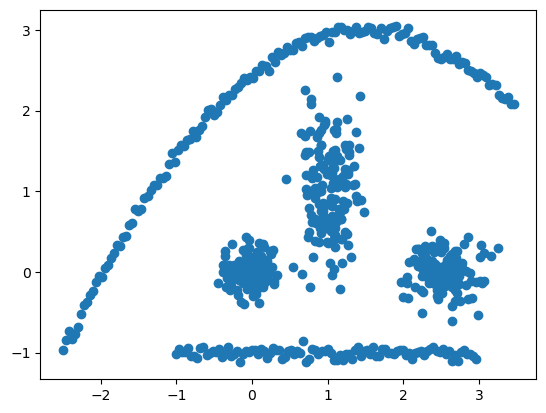

In [2]:
P = [(np.random.randn()/6, np.random.randn()/6) for i in range(150)]
P.extend([(np.random.randn()/4 + 2.5, np.random.randn()/5) for i in range(150)])
P.extend([(np.random.randn()/5 + 1, np.random.randn()/2 + 1) for i in range(150)])
P.extend([(i/25 - 1, + np.random.randn()/20 - 1) for i in range(100)])
P.extend([(i/25 - 2.5, 3 - (i/50 - 2)**2 + np.random.randn()/20) for i in range(150)])

plt.scatter(np.array(P)[:, 0], np.array(P)[:, 1])

### Реализация DBSCAN алгоритма

In [3]:
class DBSCAN_naive:
    def __init__(self, distance, eps, m, points_array):
        """
        Простая реализация алгоритма DBSCAN
        input:
        - distance: метрика расстояния между 2умя точками
        - eps: Максимальное расстояние между точками 
        - m: Минимальное количество соседей у точки, чтобы стать корневой
        - points_array: Данные для кластеризации
        """
        self.distance = distance
        self.eps = eps
        self.m = m
        self.noise_cluster = 0
        self.cluster_dict = {self.noise_cluster: []}# заранее определим кластер шума
        self.cluster_count = 0
        self.visited_points = set()
        self.clustered_points = set()
        self.points_array = points_array
        
    def region_query(self, p):
        """
        Определение точек-соседей
        input:
        - p - новая точка датасета
        """
        return [q for q in  self.points_array if self.distance(p, q) < self.eps] 
    
    def expand_cluster(self, p, neighbours):
        """
        Функция поиска корневых точек кластера
        input:
        - p - новая точка датасета
        - neighbours - соседи этой точки
        """
        if self.cluster_count not in self.cluster_dict:
            self.cluster_dict[self.cluster_count] = []
        
        # добавляем в кластер новую точку
        self.cluster_dict[self.cluster_count].append(p)
        # переводим точку в статус кластеризованных
        self.clustered_points.add(p)
        
        # идем по соседям точки
        while neighbours:
            q = neighbours.pop()
            
            # если с точкой-соседом еще не работали
            if q not in self.visited_points:
                self.visited_points.add(q)
                # определяем ее соседей
                q_neighbours = self.region_query(q)
                # если у нее есть подходящие соседи - добавляем новых соседей к соседяем исходной корневой точки
                if len(q_neighbours) >= self.m:
                    neighbours.extend(q_neighbours)
            
            # если новая точка еще не отнесена ни к одному кластеру
            if q not in self.clustered_points:
                # относим точку к кластеру заданной точкой p
                self.clustered_points.add(q)
                self.cluster_dict[self.cluster_count].append(q)
                # если эта точка была до этого в шумовом кластере, удалим ее оттуда - она уже не шум
                if q in self.cluster_dict[self.noise_cluster]:
                    self.cluster_dict[self.noise_cluster].remove(q)
                    
    def fit(self, points_array):
        for p in points_array:
            if p not in self.visited_points:
                self.visited_points.add(p)
                # определяем соседей точки
                neighbours = self.region_query(p)
                # если количество соседей меньше минимального, то добавляем в кластер шума
                if len(neighbours) < self.m:
                    self.cluster_dict[self.noise_cluster].append(p)
                else:
                    # в другом случае - новая точка становится кластером
                    self.cluster_count += 1
                    # определяем к каким кластерам относятся соседи точки
                    self.expand_cluster(p, neighbours)
               

            
# hypot - функция расчета евклидова расстояния
dbscan = DBSCAN_naive(lambda x, y: hypot(x[0] - y[0], x[1] - y[1]), 0.3, 2, P)
dbscan.fit(P)

In [4]:
print('Total cluster size: ', len(dbscan.cluster_dict))

Total cluster size:  5


### Визуализируем полученные кластеры

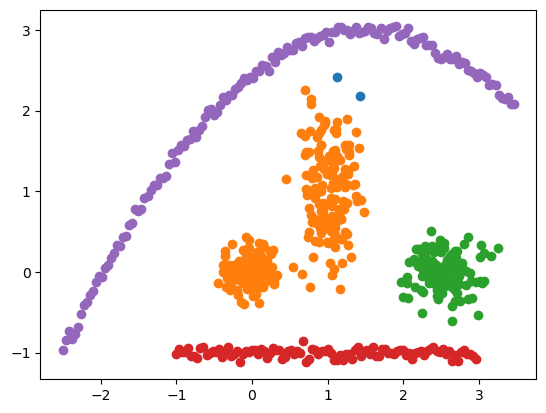

In [5]:
for key in dbscan.cluster_dict:
    points_list = np.array(dbscan.cluster_dict[key])
    if len(points_list) > 0:
        plt.scatter(points_list[:, 0], points_list[:, 1])

In [6]:
dbscan.cluster_dict[0]# шумовые точки(аномалии)

[(1.424617477749639, 2.1854473788551934),
 (1.1271637291142584, 2.413277992160917)]